**<p align = center><font size = 10 color = brown>Fraud Detection</font></p>**
**<p align = center><font size = 5 color = green>By Prabhat Kumar</font></p>**

In [1]:
# importing libraries for data processing
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# importing libraries for visulization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from xgboost import plot_tree

# importing models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# importing libraries for performance analysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, r2_score, roc_auc_score, average_precision_score

import warnings
warnings.filterwarnings("ignore")

C:\Users\prabh\miniconda3\envs\tf_gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Dataset exploration

In [2]:
# loading the dataset
df = pd.read_csv('fraud.csv')

The dataset have 11 features which are as follows:

- **step -** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- **type -** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- **amount -** amount of the transaction in local currency.

- **nameOrig -** customer who started the transaction

- **oldbalanceOrg -** initial balance before the transaction

- **newbalanceOrig -** new balance after the transaction

- **nameDest -** customer who is the recipient of the transaction

- **oldbalanceDest -** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- **newbalanceDest -** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- **isFraud -** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- **isFlaggedFraud -** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [3]:
# Seeing the first 5 rows of our dataframe
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Getting familiar with the features and their data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


#### Checking if any of the feature is having a missing sample in our databse 

In [5]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Describing the dataset

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Number of transactions labelled or flagged as fraudulant

In [7]:
print("The number of trasaction labeled as Fradulent are {}".format(df[df['isFraud'] == 1]['isFraud'].count()))
print("The number of trasaction labeled as NOT Fradulent are {}".format(df[df['isFraud'] == 0]['isFraud'].count()))

The number of trasaction labeled as Fradulent are 8213
The number of trasaction labeled as NOT Fradulent are 6354407


In [8]:
print("The number of trasaction Flagged as Fradulent are {}".format(df[df['isFlaggedFraud'] == 1]['isFlaggedFraud'].count()))
print("The number of trasaction Flagged as NOT Fradulent are {}".format(df[df['isFlaggedFraud'] == 0]['isFlaggedFraud'].count()))

The number of trasaction Flagged as Fradulent are 16
The number of trasaction Flagged as NOT Fradulent are 6362604


### Checking the fractions of fraudulent and non fraudulent transactions.

In [9]:
fraud_fraction = df['isFraud'].value_counts()/len(df.index)
print("Fraudulent transaction = 1, NON fraudulent transaction = 0\n",fraud_fraction)

Fraudulent transaction = 1, NON fraudulent transaction = 0
 0    0.998709
1    0.001291
Name: isFraud, dtype: float64


In [10]:
flagged_fraud_fraction = df['isFlaggedFraud'].value_counts()/len(df.index)
print("Flagged fraudulent transaction = 1, flagged NON fraudulent transaction = 0\n", flagged_fraud_fraction)

Flagged fraudulent transaction = 1, flagged NON fraudulent transaction = 0
 0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64


<font color = red>**NOTE: We can observe that the difference between thefractions of fraudulent and non fraudulent transactions are very large. This means that the data is very imbalanced.**</font> 

## Visualizing the dataset

#### Plotting the correlation matrix

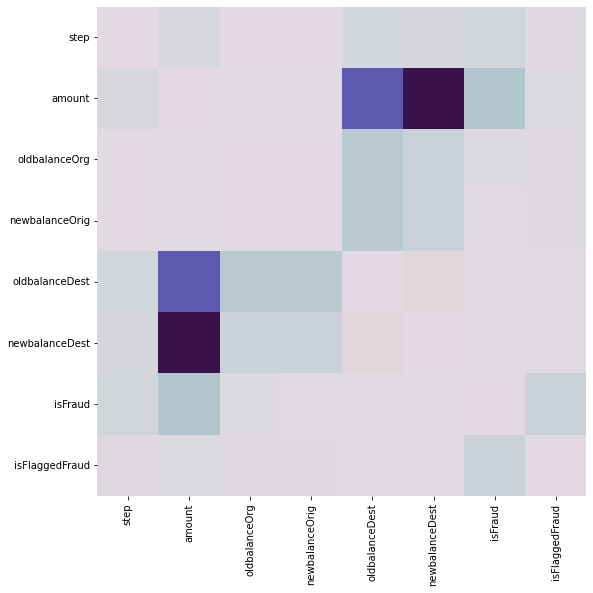

In [11]:
# plotting the correaltion matrix

corr_mat = df.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corr_mat, cmap = 'twilight', square = True, cbar=False, fmt = ".2g")
plt.show()

#### Plotting the normal distribution of steps 

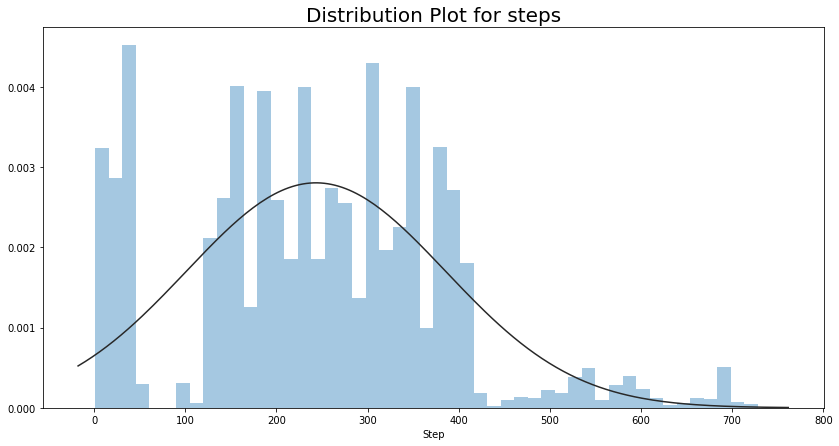

In [12]:
# plotting the normal distribution of steps

plt.figure(figsize = (14, 7))
sns.distplot(df['step'], fit = stats.norm, kde = False)
plt.title('Distribution Plot for steps', fontsize = 20)
plt.xlabel('Step', fontsize = 10)
plt.show()

#### Visualizing the most common transaction amounts

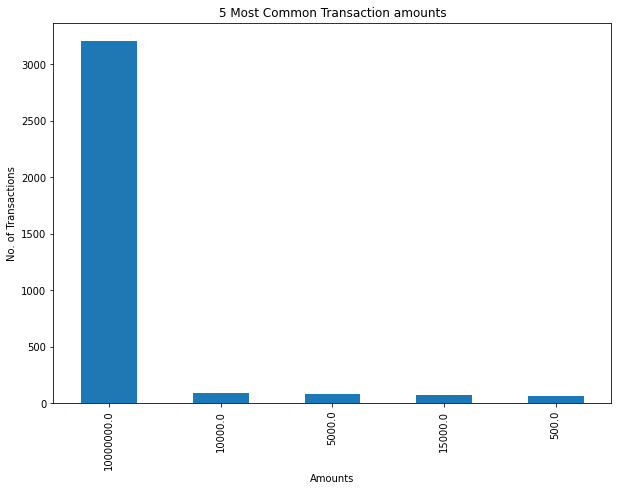

In [13]:
# plotting the most common transactions

plt.figure(figsize = (10, 7))
df['amount'].value_counts().head().plot.bar()
plt.title('5 Most Common Transaction amounts')
plt.xlabel('Amounts')
plt.ylabel('No. of Transactions')
plt.show()

## Knowing better about fraudulent transactions

Grouping the transactions according to their types.

In [14]:
fraud_type = df.groupby('type')['isFraud'].count()
fraud_type

type
CASH_IN     1399284
CASH_OUT    2237500
DEBIT         41432
PAYMENT     2151495
TRANSFER     532909
Name: isFraud, dtype: int64

There are 5 types of transactions, **`CASH_IN`**, **`CASH_OUT`**, **`DEBIT`**, **`PAYMENT`**, and **`TRANSFER`**.

Now we check the instances where fraudulent transactions have taken place

In [15]:
fraud_cashin = df[(df['isFraud'] == 1) & (df['type'] == 'CASH_IN')]
fraud_cashout = df[(df['isFraud'] == 1) & (df['type'] == 'CASH_OUT')]
fraud_debit = df[(df['isFraud'] == 1) & (df['type'] == 'DEBIT')]
fraud_payment = df[(df['isFraud'] == 1) & (df['type'] == 'PAYMENT')]
fraud_transfer = df[(df['isFraud'] == 1) & (df['type'] == 'TRANSFER')]

In [16]:
print ('Instances of fraudulent CASH_OUT = {}'.format(len(fraud_cashout)))
print ('Instances of fraudulent CASH_IN = {}'.format(len(fraud_cashin)))
print ('Instances of fraudulent DEBIT = {}'.format(len(fraud_debit)))
print ('Instnaces of fraudulent PAYMENT = {}'.format(len(fraud_payment)))
print ('Instances of fraudulent TRANSFER = {}'.format(len(fraud_transfer)))

Instances of fraudulent CASH_OUT = 4116
Instances of fraudulent CASH_IN = 0
Instances of fraudulent DEBIT = 0
Instnaces of fraudulent PAYMENT = 0
Instances of fraudulent TRANSFER = 4097


<font color = green>We can see that only in the case of **`CASH_OUT`** and **`TRANSFER`**, the fradulant transaction have taken place.</font>

Now we check the minimum and maximum amount transactioned for the **`Cash_OUT`** and **`TRANSFER`**

In [17]:
print("Minimum Transaction for 'CASH_OUT' which are fraudulent = {}".format(df[(df['isFraud'] == 1) & (df['type'] == 'CASH_OUT')].amount.min()))
print("Maximum Transaction for 'CASH_OUT' which are fraudulent = {}".format(df[(df['isFraud'] == 1) & (df['type']== 'CASH_OUT')].amount.max()))

Minimum Transaction for 'CASH_OUT' which are fraudulent = 0.0
Maximum Transaction for 'CASH_OUT' which are fraudulent = 10000000.0


In [18]:
print("Minimum Transaction for 'TRANSFER' which are fraudulent = {}".format(df[df['isFraud'] == 1 & (df['type'] == 'TRANSFER')].amount.min()))
print("Maximum Transaction for 'TRANSFER' which are fraudulent = {}".format(df[(df['isFraud'] == 1) & (df['type'] == 'TRANSFER')].amount.max()))

Minimum Transaction for 'TRANSFER' which are fraudulent = 0.01
Maximum Transaction for 'TRANSFER' which are fraudulent = 10000000.0


#### Checking the number of Flagged fraudulent transactions

In [19]:
flagged_fraud_cashout = df[(df['isFlaggedFraud'] == 1) & (df['type'] == 'CASH_OUT')]
print("The no. of Flagged Fraudulent 'CASH_OUT' Transactions are {}".format(len(flagged_fraud_cashout)))

The no. of Flagged Fraudulent 'CASH_OUT' Transactions are 0


In [20]:
flagged_fraud_transfer = df[(df['isFlaggedFraud'] == 1) & (df['type'] == 'TRANSFER')]
print("The no. of Flagged Fraudulent 'TRANSFER' Transactions are {}".format(len(flagged_fraud_transfer)))

The no. of Flagged Fraudulent 'TRANSFER' Transactions are 16


<font color = green>We can see that only the **`TRANSFER`** transactions are flagged as fraudulent</font>

Checking the maximum and minimum amount transactioned for flagged fraudulent transactions

In [21]:
print("Minimum Transaction for 'TRANSFER' which are flagged fraudulent = {}".format(df[df['isFlaggedFraud'] == 1].amount.min()))
print("Maximum Transaction for 'TRANSFER' which are flagged fraudulent = {}".format(df[df['isFlaggedFraud'] == 1].amount.max()))

Minimum Transaction for 'TRANSFER' which are flagged fraudulent = 353874.22
Maximum Transaction for 'TRANSFER' which are flagged fraudulent = 10000000.0


#### Gethering the knowledge about the `flagged` fraudulent transactions

In [22]:
# creating a dataframe with transfer only as a type of transactions
df_transfer = df[df['type'] == 'TRANSFER']
df_transfer.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0


<font color = orange>**In case of `TRABSFER` if the old balance and the new balance remains same after completion of a transaction, it is a fraudulent tanasaction because sender had sent the money but his/her account balance is not changed**</font>

Checking the cases where the origional old balance and new balance are same and those transfer transactions are flagged as fraudulent. 

In [23]:
df_transfer[(df_transfer['isFlaggedFraud'] == 1) & (df_transfer['oldbalanceOrg'] == df_transfer['newbalanceOrig'])].sort_values(by = 'oldbalanceOrg').head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6351225,702,TRANSFER,3171085.59,C1892216157,3171085.59,3171085.59,C1308068787,0.0,0.0,1,1


Knowing the minimum and maximum balance amount of the the senders which are transactioned and are flagged as fraudulent

In [24]:
df_flagged = df[df['isFlaggedFraud'] == 1]

print("Minimum Balance of 'oldBalanceOrg' for falgged fraudulent transactions is {}".format(df_flagged['oldbalanceOrg'].min()))
print("Maximum Balance of 'oldbalanceOrg' for flagged fraudulent transactions is {}".format(df_flagged['oldbalanceOrg'].max()))

Minimum Balance of 'oldBalanceOrg' for falgged fraudulent transactions is 353874.22
Maximum Balance of 'oldbalanceOrg' for flagged fraudulent transactions is 19585040.37


## Data preperation for regression

Since fraudulent transaction only happend for `CASH_OUT` and `TRANSFER` type of transactions, we define a dataframe `X` which will only have the data related to `CASH_OUT` and `TRANSFER`.

In [25]:
X = df[(df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')]
X.shape

(2770409, 11)

In [26]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


<font color = red>**Since the features `nameDest` and `nameOrig` are not very much useful because recipient customer name and name of person who started a transaction is not that much correlated to the transactions and does not provide much information about wether the transaction will be fraudulent or not. We will drop these two features.**</font>

In [27]:
# dropping the unwanted columns

X = X.drop(['nameDest','nameOrig'], axis = 1)
X.shape

(2770409, 9)

<font color = orange>**We add two new feature `errorBalanceOrig` and `errorBalanceDest` to the database which will provide information about the error in the initial balance before the transaction, the amount transactioned and new balance after the transaction for both the person who initiated the transaction and the recipient customer.**</font>

In [28]:
# adding two new features to the X

X['errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
X['errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']
X.shape

(2770409, 11)

In [29]:
# hot coding the CASH_OUT and TRANSFER to convert them to categotical variables

X['type'].replace('CASH_OUT', 0, inplace = True)
X['type'].replace('TRANSFER', 1, inplace = True)

In [30]:
# visualizing the new dataset
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
2,1,1,181.00,181.0,0.0,0.0,0.00,1,0,0.00,181.0
3,1,0,181.00,181.0,0.0,21182.0,0.00,1,0,0.00,21363.0
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,0,213808.94,182703.5
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,0,214605.30,237735.3
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,300850.89,-2401220.0


In [31]:
# checking the number of fraudulent and non fraudulent transactions in the new dataframe 

X['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

Splitting the target variable from input variable by dropping the `isFraud` from the `x` and storing it into a new variable `y`

In [32]:
x = X.drop(['isFraud'] , axis = 1)
y = X['isFraud']

In [33]:
print('shape of x : {}\nshape of y : {}'.format(x.shape, y.shape))

shape of x : (2770409, 10)
shape of y : (2770409,)


In [34]:
# visualizing the input variable data

x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
2,1,1,181.00,181.0,0.0,0.0,0.00,0,0.00,181.0
3,1,0,181.00,181.0,0.0,21182.0,0.00,0,0.00,21363.0
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0


In [35]:
# visualizing the target variable data

y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

### Balancing the data using Synthetic Minority Oversampling Technique (SMOTE).
SMOTE is a type of data augmentation of the minority class (fraudulent transactions in this scenario) to oversample the dataset by duplicating the existing information without adding any new information to the dataset.

In [36]:
# from imblearn.over_sampling import SMOTE

balancer = SMOTE()
x_resampled, y_resampled = balancer.fit_resample(x, y)

print('shape of x : {}\nshape of y : {}'.format(x_resampled.shape, y_resampled.shape))

shape of x : (5524392, 10)
shape of y : (5524392,)


Knowing the instances of fraudulent and NON fraudulent transaction in the dataset after applying SMOTE to oversample the data. 

In [37]:
y_resampled.value_counts()

1    2762196
0    2762196
Name: isFraud, dtype: int64

<font color = green>After applying `SMOTE` we can see that the fraudulent transactions are oversampled and both the fraudulent and NON fraudulent transactions have similar fractctions in the database now.</font>

Splitting the dataset into training and testing dataset with 80% data as training data and 20% data as testing data

In [64]:
# from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.4, random_state = 42)

In [39]:
# Knowing the shape of training and testing dataset

print("Shape of x_train = {} ".format(x_train.shape))
print("Shape of y_train = {}".format(y_train.shape))
print("Shape of x_test = {}".format(x_test.shape))
print("Shape of y_test = {}".format(y_test.shape))

Shape of x_train = (3314635, 10) 
Shape of y_train = (3314635,)
Shape of x_test = (2209757, 10)
Shape of y_test = (2209757,)


In [40]:
x_train

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
4265164,26,0,120351.924939,120351.924939,0.00,0.000000e+00,1.203519e+05,0,0.00,0.000000e+00
952326,184,0,215613.940000,0.000000,0.00,2.871579e+06,3.087193e+06,0,215613.94,0.000000e+00
5383264,381,0,160405.796488,160405.796488,0.00,1.352438e+06,1.512844e+06,0,0.00,0.000000e+00
1532483,258,0,9722.600000,66169.000000,56446.40,1.557455e+05,1.654681e+05,0,0.00,0.000000e+00
1998023,327,0,317194.780000,50375.000000,0.00,1.951734e+06,2.268929e+06,0,266819.78,-1.000000e-02
...,...,...,...,...,...,...,...,...,...,...
1570006,261,0,107205.810000,21187.000000,0.00,6.807793e+05,7.879851e+05,0,86018.81,1.164153e-10
2234489,355,0,20115.010000,21359.000000,1243.99,0.000000e+00,2.011501e+04,0,0.00,0.000000e+00
4926484,361,1,621312.363522,621312.363522,0.00,0.000000e+00,0.000000e+00,0,0.00,6.213124e+05
4304572,232,1,273814.775087,273814.775087,0.00,0.000000e+00,0.000000e+00,0,0.00,2.738148e+05


Data Sampling

In [41]:
x_train_df = x_train
x_train_df['isFraud'] = y_train

In [42]:
sample_1 = x_train_df.sample(frac = 0.7)
sample_2 = x_train_df.sample(frac = 0.7)
sample_3 = x_train_df.sample(frac = 0.7)
sample_4 = x_train_df.sample(frac = 0.7)
sample_5 = x_train_df.sample(frac = 0.7)

In [43]:
sample_1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,isFraud
2717501,594,0,6.566075e+04,0.000000e+00,0.0,1.421829e+07,1.428395e+07,0,65660.75,0.000000e+00,0
2543337,401,0,1.125022e+05,0.000000e+00,0.0,2.297154e+06,2.409657e+06,0,112502.24,0.000000e+00,0
3242866,350,1,2.742031e+06,2.742031e+06,0.0,0.000000e+00,0.000000e+00,0,0.00,2.742031e+06,1
4254756,397,0,8.624923e+05,8.624923e+05,0.0,2.034328e+06,2.896820e+06,0,0.00,0.000000e+00,1
4683669,500,1,1.290454e+06,1.290454e+06,0.0,0.000000e+00,0.000000e+00,0,0.00,1.290454e+06,1


In [44]:
x_sample_1_train = sample_1.drop('isFraud', axis = 1)
x_sample_1_test = sample_1['isFraud']

x_sample_2_train = sample_2.drop('isFraud', axis = 1)
x_sample_2_test = sample_2['isFraud']

x_sample_3_train = sample_3.drop('isFraud', axis = 1)
x_sample_3_test = sample_3['isFraud']

x_sample_4_train = sample_4.drop('isFraud', axis = 1)
x_sample_4_test = sample_4['isFraud']

x_sample_5_train = sample_5.drop('isFraud', axis = 1)
x_sample_5_test = sample_5['isFraud']

In [45]:
x_sample_1_train.shape

(2320244, 10)

In [46]:
x_sample_1_test.shape

(2320244,)

In [47]:
# from sklearn.neighbors import KNeighborsClassifier


neigh_1 = KNeighborsClassifier()
neigh_1.fit(x_sample_1_train, x_sample_1_test)

neigh_2 = KNeighborsClassifier()
neigh_2.fit(x_sample_2_train, x_sample_2_test)

neigh_3 = KNeighborsClassifier()
neigh_3.fit(x_sample_3_train, x_sample_3_test)

neigh_4 = KNeighborsClassifier()
neigh_4.fit(x_sample_4_train, x_sample_4_test)

neigh_5 = KNeighborsClassifier()
neigh_5.fit(x_sample_5_train, x_sample_5_test)

KNeighborsClassifier()

In [48]:
neigh_1.score(x_test,y_test)

0.9939377949702162

In [49]:
neigh_2.score(x_test,y_test)

0.9938916360486696

In [50]:
neigh_3.score(x_test,y_test)

0.9939554439696311

In [51]:
neigh_4.score(x_test,y_test)

0.9939287442012855

In [52]:
neigh_5.score(x_test,y_test)

0.9939853115071023

In [55]:
# from sklearn.ensemble import VotingClassifier

models = [('knn_1',neigh_1),('knn_2',neigh_2),('knn_3',neigh_3),('knn_4',neigh_4),('knn_5',neigh_5)]
ensemble = VotingClassifier(estimators=models)

In [57]:
# from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [58]:
# from sklearn.model_selection import cross_val_score

results = cross_val_score(ensemble, x_test, y_test, cv=kfold)

In [62]:
print("Mean: {}\nStandard Deviation: {}".format(results.mean() ,results.std()))

Mean: 0.9935897928669167
Standard Deviation: 0.00011477673894256647


**<p align = center><font color = 00fff00 size = 10>Training on different models</font></p>**

#### Scaling the data using `StandardScaler`. 

It Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample $x$ is calculated as:

$$\begin{aligned}z = \frac{x - \mu}{\sigma}\end{aligned}$$

Where; $\mu$ is the mean and $\sigma$ is the standard deviation 

In [65]:
# from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

**<p align = center><font color = #55fff0 size = 6>Logistic Regression</font></p>**

For training our model we will be using `Logistic Regression` with default configuration.

In [67]:
# from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

LogisticRegression()

In [68]:
# model prediction on test dataset

predicted_lr = model_lr.predict(x_test)

<p align = center><font size = 5 color = #55ff50>Performance Analysis</font></p>

#### Accuracy Score

In [69]:
# from sklearn.metrics import acuracy_score

accuracy_lr = accuracy_score(y_test,predicted_lr)
print(accuracy_lr)

0.9474842708949446


Our model got a accuracy of 94.8% which is great but it is on vanilla Logistic regression as a model with `lbfgs` as a solver. We can either optimize this by tuning hyperparameters or alternatively train the model using Ensemble learning techniques such as `XGBoost`.

#### Classification report

In [70]:
# Print the classifcation report and confusion matrix

# from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_lr))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95   1104404
           1       0.95      0.95      0.95   1105353

    accuracy                           0.95   2209757
   macro avg       0.95      0.95      0.95   2209757
weighted avg       0.95      0.95      0.95   2209757



#### Confusion Matrix

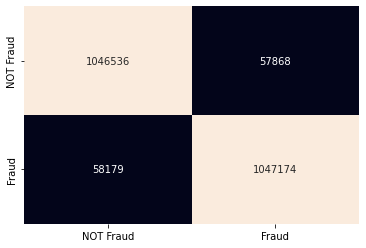

In [71]:
# from sklearn.metrics import confusion_matrix

labels = {'NOT Fraud':0, 'Fraud':1}
cm = confusion_matrix(y_true=y_test, y_pred=predicted_lr)
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels= labels, yticklabels= labels, cbar = False)
plt.show()

We can clearly notice that our **False Positive** and **False Negative** values are **58179** and **58786** respectively which are very high. 

In [72]:
# from sklearn.metrics import r2_score

r_saquare = r2_score(y_true=y_test, y_pred=predicted_lr)
print("R Squared = {}".format(r_saquare))

R Squared = 0.7899370448368128


The $R^2$ = 0.79 which is good in this scenario.

In [73]:
# from sklearn.metrics import roc_acu_score

aucroc_lr_test = roc_auc_score(y_true=y_test, y_score=predicted_lr)
print("The area under AUC and ROC for predicted test value are {}".format(aucroc_lr_test))

The area under AUC and ROC for predicted test value are 0.9474843216510388


The area under the AUC and ROC curve is 0.94 which is also good.

In [74]:
# from sklearn.metrics import average_precision_score

prc_lr_test = average_precision_score(y_true=y_test, y_score=predicted_lr)
print("The area under precision recall curve for predicted test value are {}".format(prc_lr_test))

The area under precision recall curve for predicted test value are 0.9240834196959453


The area under the precison recall curve is 0.92 wihch is good but the **False Negative** and the **False Positive** are very high. 

We now train out model on `XGBRegressor` to get maybe better results. Let's find out.

**<p align = center><font color = #55fff0 size = 6>Applying XGBRegressor</font></p>**

We train our data on `XGBRegressor` which is regression using XGBoost. We will be using 20 weak classifiers with each tree having a maximum depth of 2 and default base score of 0.5.

In [75]:
# from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=2)
model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Plotting the first `tree` in the `XGBRegressor`

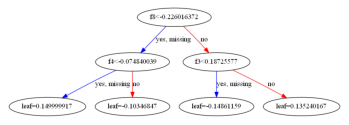

In [76]:
# from xgboost import plot_tree
plot_tree(model_xgb)
plt.show()

#### Knowing the importance of features present in our modified dataset. 

In [77]:
importance_df_xgb = pd.DataFrame({'feature': x.columns,'importance': model_xgb.feature_importances_}).sort_values('importance', ascending=False)

In [78]:
importance_df_xgb

,feature,importance
8,errorBalanceOrig,0.743017
4,newbalanceOrig,0.132437
9,errorBalanceDest,0.038376
2,amount,0.035844
6,newbalanceDest,0.025383
3,oldbalanceOrg,0.021411
7,isFlaggedFraud,0.003001
0,step,0.000531
1,type,0.000000
5,oldbalanceDest,0.000000


<font color = orange>**The `errorBalanceOrig` feature which was intoduced by us earlier in the data preperation for the model training turned out to the most important feature for training the XGBRegressor. Yay!**</font>

<p align = center><font size = 5 color = #55ff50>Performance Analysis</font></p>

In [79]:
x_preds_xgb = model_xgb.predict(x_train)
prc_xgb_train = average_precision_score(y_train, x_preds_xgb)
print("The area under precision recall curve for x_train is {}".format(prc_xgb_train))

The area under precision recall curve for x_train is 0.9989688706073776


In [80]:
y_preds_xgb = model_xgb.predict(x_test)
prc_xgb_test = average_precision_score(y_test, y_preds_xgb)
print("The area under precision recall curve for x_test is {}".format(prc_xgb_test))

The area under precision recall curve for x_test is 0.9989679836102381


<font color = red>From the above results we can clearly see the better performance of `XGBRegressor`</fomt>

#### Accuracy of XGBoost model

In [81]:
predicted_xgb = (y_preds_xgb > 0.5)

accuracy_xgb=accuracy_score(y_test,predicted_xgb)
print("The accuracy of XGBoost model is {}".format(accuracy_xgb))

The accuracy of XGBoost model is 0.9977481686900415


We got a accuracy of 99.8% which is very impressive.

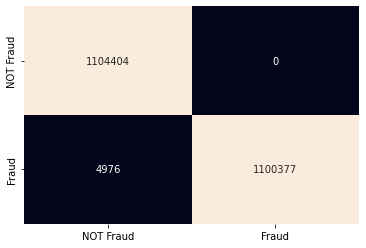

In [82]:
labels = {'NOT Fraud':0, 'Fraud':1}
cm = confusion_matrix(y_true=y_test, y_pred=predicted_xgb)
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels= labels, yticklabels= labels, cbar = False)
plt.show()

We can also note that the **False Negative** and the **False Positive** have been significantly decreased.

In [83]:
r_saquare_xgb = r2_score(y_true=y_test, y_pred=predicted_xgb)
print("R Squared = {}".format(r_saquare_xgb))

R Squared = 0.9909926730988994


In [84]:
aucroc_xgb_pred = roc_auc_score(y_true=y_test, y_score=predicted_xgb)
print("The area under AUC and ROC for predicted test value are {}".format(aucroc_xgb_pred))

The area under AUC and ROC for predicted test value are 0.9977491353440937


In [85]:
prc_xgb_pred = average_precision_score(y_true=y_test, y_score=predicted_xgb)
print("The area under precision recall curve for predicted test value are {}".format(prc_xgb_pred))

The area under precision recall curve for predicted test value are 0.997750101998146


In [86]:
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1104404
           1       1.00      1.00      1.00   1105353

    accuracy                           1.00   2209757
   macro avg       1.00      1.00      1.00   2209757
weighted avg       1.00      1.00      1.00   2209757



<font color = red>**We can now conclude that we have trained a model which is robust enough to predict wether a transaction is fraudulant or not which an accuracy of $99.8\%$. We also processed and visualized many aspects of the data and also introduces two new features to the data which in the end turnes out to be the most important features in the training of `XGBRegressor` model.**</font>